# \begin{equation*} \frac{D \sigma}{D t} = \dot\sigma_{\theta} = \frac{\partial \sigma_{\theta}}{\partial \theta} \dot\theta + \frac{\partial \sigma_{\theta}}{\partial S} \dot S \end{equation*}
## **SOSE**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=25)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [22]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.0b1bd95e263042a29a0f53e455c57fc9 Dashboard: /services/dask-gateway/clusters/prod.0b1bd95e263042a29a0f53e455c57fc9/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [101]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline
import fastjmd95.jmd95numba as jmd95numba
#from fastjmd95 import jmd95numba
#from fastjmd95 import rho, drhods, drhodt

In [4]:
xr.set_options(display_style='text')

In [5]:
#coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')) not wg region
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/coords.zarr'))
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns.zarr'))
#ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_slt_wg.zarr')) old ds, surf/lin-fs terms 2D
#ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tmp_wg.zarr')) old ds, surf/lin-fs terms 2D
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_slt.zarr'))
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_th.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_slt, ds_tmp, ds_vel])

In [6]:
coords = coords.roll(XC=700, XG=700)
ds = ds.roll(XC=700, XG=700)

<ipython-input-6-cc4a553a0312>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords = coords.roll(XC=700, XG=700)
<ipython-input-6-cc4a553a0312>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = ds.roll(XC=700, XG=700)


In [7]:
ds

<xarray.Dataset>
Dimensions:                   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 243.41667 243.58334 ... 243.25
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 243.33334 243.5 ... 243.0 243.16667
  * YG                        (YG) float32 -77.9583 -77.79163 ... -24.791632
  * Zl                        (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    SALT                      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    THETA                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    sw_flux_conv_TH           (time, YC, XC, Z) float32 dask.array<chunksize=(1, 320, 2160, 42), meta=np.ndarray>
    total_tendency_TH_truth   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [8]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
#WG model's boundaries after .roll(XC=700) (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #YG=-77.9583
upper_lat = 95
left_lon =  310
right_lon = 880

YG_upper = 96 #-61.9583
#XG_left = 311 #295.1667
XG_right = 881 #30.166668

In [9]:
#set the boundaries
lat_range_noface = dict(YC=slice(lower_lat, upper_lat))
lon_range_noface = dict(XC=slice(left_lon, right_lon))

In [10]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat), YG=slice(lower_lat, YG_upper))
lon_range = dict(XC=slice(left_lon, right_lon), XG=slice(left_lon, XG_right))

In [11]:
coords_wg = coords.isel(**lat_range, **lon_range)
ds_wg = ds.isel(**lat_range, **lon_range)

In [12]:
pref = 2000

# <font color='Green'> \begin{equation*} Temperature \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta}\end{equation*} </font>

In [15]:
jmd95numba.drhods?

Call signature:  jmd95numba.drhods(*args, **kwargs)
Type:            DUFunc
String form:     <numba._DUFunc 'drhods'>
File:            /srv/conda/envs/notebook/lib/python3.8/site-packages/numba/np/ufunc/dufunc.py
Docstring:      
Computes partial derivative of density with respect to practical salinity
using Jackett and McDougall 1995 polynomial [1]_.

Parameters
----------
s : array_like
    practical salinity [psu (PSS-78)]
theta : array_like
    potential temperature [degree C (IPTS-68)];
    same shape as s
p : array_like
    pressure [dbar]; broadcastable to shape of s

Returns
-------
drhods : array
    partial derivative of density with respect to practical salinity
    [kg/m^3/psu]

Example
-------
>>> drhods(35.5, 3., 3000.)
0.77481

Notes
-----
Adopted from `MITgcm python utils <https://github.com/MITgcm/MITgcm/blob/master/utils/python/MITgcmutils/MITgcmutils/jmd95.py>`_.

.. [1] Jackett, D.R. and T.J. Mcdougall, 1995: Minimal Adjustment of
Hydrographic Profiles to Achieve St

In [20]:
ds_wg.THETA

<xarray.DataArray 'THETA' (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<getitem, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Potential Temperature
    standard_name:  THETA
    units:          degC

In [21]:
ds_wg.SALT

<xarray.DataArray 'SALT' (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<getitem, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

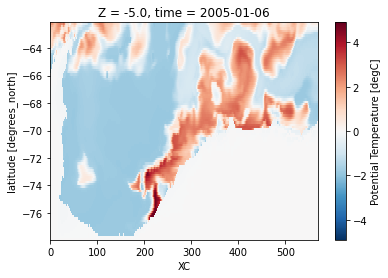

In [14]:
ds_wg.THETA[0,0].drop('XC').plot()

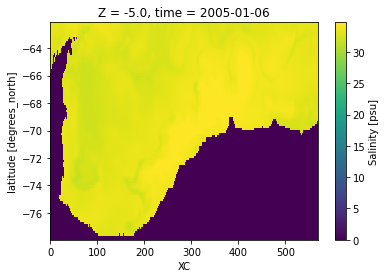

In [97]:
ds_wg.SALT[0,0].drop('XC').plot()

In [18]:
ds.THETA

<xarray.DataArray 'THETA' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<rechunk-merge, shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 243.41667 243.58334 243.75 ... 243.08334 243.25
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Potential Temperature
    standard_name:  THETA
    units:          degC

In [19]:
ds.SALT

<xarray.DataArray 'SALT' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<rechunk-merge, shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 243.41667 243.58334 243.75 ... 243.08334 243.25
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

attempts at solving the error
1. `.drop('XC')` to see if it was a rolled coords issue
2. deleted `reset_coords(drop=True)`
3. tried on unrolled ds
4. tried `drhods`
5. not a memory issue (tried large size during login and used 25 workers, plus this worked for ECCO when it ran before quals)
6. Numba issue? Maybe conversion from dask array to NumPy array?

### **Meeting w Ryan 11/30:**
1. `xr_unfunc()`
2. `dsa_mapblocks()`
3. `xr.mapblocks()`
4. model data
5. randomized data
7. fastjmd95
8. simple function (a+b+c)

In [15]:
import xarray as xr
from fastjmd95 import jmd95numba
import dask.array as dsa

In [17]:
ds.THETA.data

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2629 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [16]:
#Randomized data
shape = (438, 42, 320, 2160)
chunks = (1, 42, 320, 2160)
#salt = dsa.full(shape, 35., chunks=chunks, dtype='f4')
#theta = dsa.full(shape, 10., chunks=chunks, dtype='f4')
salt = dsa.random.random(shape, chunks=chunks).astype('f4')
theta = dsa.random.random(shape, chunks=chunks).astype('f4')
pref = 2000
salt

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,876 Tasks,438 Chunks
Type,float32,numpy.ndarray


### 1. **`xr.apply_ufunc()`-`fastjmd95`-model data**

In [20]:
drhodt_ufunc = xr.apply_ufunc(jmd95numba.drhodt, ds.SALT, ds.THETA, pref,
                              output_dtypes=[ds.THETA.dtype],
                              dask='parallelized').reset_coords(drop=True)
drhodt_ufunc.data

,Array,Chunk
Bytes,101.72 GB,232.24 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,6573 Tasks,438 Chunks
Type,float64,numpy.ndarray


In [23]:
%%time
drhodt_ufunc.mean(dim=('time', 'Z')).compute()

CPU times: user 3.68 s, sys: 124 ms, total: 3.8 s
Wall time: 2min 19s


<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       [-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       [-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       ...,
       [-0.16931999, -0.16931836, -0.16931146, ..., -0.17225057,
        -0.17226287, -0.17226999],
       [-0.16932089, -0.16932144, -0.16931663, ..., -0.17224326,
        -0.17225843, -0.17226721],
       [-0.1690969 , -0.16909527, -0.16908666, ..., -0.17204258,
        -0.17204542, -0.17205131]])
Coordinates:
  * XC       (XC) float32 243.41667 243.58334 243.75 ... 243.08334 243.25
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083

### 2. **`xr.apply_ufunc()`-`fastjmd95`-randomized data**

In [17]:
salt

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,876 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [18]:
dummy_ds = xr.Dataset({'theta':(['time', 'Z','YC','XC'], theta),
                       'salt': (['time', 'Z','YC','XC'], salt)
                      })

In [19]:
dummy_ds.salt

<xarray.DataArray 'salt' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<astype, shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160), chunktype=numpy.ndarray>
Dimensions without coordinates: time, Z, YC, XC

In [20]:
drhodt_ufunc_random = xr.apply_ufunc(jmd95numba.drhodt, dummy_ds.salt, dummy_ds.theta, pref,
                              output_dtypes=[dummy_ds.theta.dtype],
                              dask='parallelized').reset_coords(drop=True)
drhodt_ufunc_random.data

,Array,Chunk
Bytes,101.72 GB,232.24 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,3067 Tasks,438 Chunks
Type,float64,numpy.ndarray


In [ ]:
%%time
drhodt_ufunc_random.mean(dim=('time', 'Z')).compute()

### 3. **`xr.apply_ufunc()`-`sum()`-model data**
Runtime:

In [24]:
def dummy_function(a, b, c):
    return a + b + c

dummy_ufunc = xr.apply_ufunc(dummy_function, ds.SALT, ds.THETA, pref,
                        output_dtypes=[ds.THETA.dtype],
                        dask='parallelized').reset_coords(drop=True)

In [31]:
dummy_ufunc.data

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,6573 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [32]:
%time dummy_ufunc.mean(dim=('time', 'Z')).compute()

CPU times: user 1.06 s, sys: 66 ms, total: 1.13 s
Wall time: 30.3 s


<xarray.DataArray (YC: 320, XC: 2160)>
array([[2000.    , 2000.    , 2000.    , ..., 2000.    , 2000.    ,
        2000.    ],
       [2000.    , 2000.    , 2000.    , ..., 2000.    , 2000.    ,
        2000.    ],
       [2000.    , 2000.    , 2000.    , ..., 2000.    , 2000.    ,
        2000.    ],
       ...,
       [2035.1166, 2035.1174, 2035.1172, ..., 2035.9713, 2035.9744,
        2035.9763],
       [2035.1152, 2035.1163, 2035.1163, ..., 2035.9686, 2035.9722,
        2035.9744],
       [2035.0885, 2035.0894, 2035.089 , ..., 2035.9457, 2035.9469,
        2035.9489]], dtype=float32)
Coordinates:
  * XC       (XC) float32 243.41667 243.58334 243.75 ... 243.08334 243.25
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083

### 4. **`xr.apply_ufunc()`-`sum()`-randomized data**
Runtime:

In [26]:
dummy_ufunc_random = xr.apply_ufunc(dummy_function, dummy_ds.salt, dummy_ds.theta, pref,
                        output_dtypes=[dummy_ds.theta.dtype],
                        dask='parallelized').reset_coords(drop=True)

In [27]:
%time dummy_ufunc_random.mean(dim=('time', 'Z')).compute()

CPU times: user 1.93 s, sys: 178 ms, total: 2.11 s
Wall time: 23min 32s


<xarray.DataArray (YC: 320, XC: 2160)>
array([[2000.9958, 2001.0055, 2001.0011, ..., 2000.9985, 2000.9994,
        2001.002 ],
       [2000.9965, 2000.9985, 2000.9937, ..., 2000.9985, 2001.0006,
        2000.9956],
       [2000.9998, 2000.9989, 2001.0006, ..., 2000.9974, 2001.0011,
        2001.0002],
       ...,
       [2000.9995, 2000.9955, 2001.0011, ..., 2000.9972, 2001.0005,
        2000.9967],
       [2001.0042, 2000.9998, 2000.9991, ..., 2001.002 , 2001.0033,
        2001.0024],
       [2000.998 , 2000.992 , 2001.002 , ..., 2001.0037, 2000.9972,
        2000.9983]], dtype=float32)
Dimensions without coordinates: YC, XC

### 5. **`dsa.map_blocks()`-`fastjmd95`-model data**
Runtime:

In [38]:
drhodt_dsa_mapped = dsa.map_blocks(
         jmd95numba.drhodt, ds.SALT.data, ds.THETA.data, pref,
         dtype=ds.SALT.dtype)
drhodt_dsa_mapped

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,5696 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [40]:
%time drhodt_dsa_mapped.mean(axis=(0, 1,)).compute()

CPU times: user 1.22 s, sys: 67.9 ms, total: 1.29 s
Wall time: 52.4 s


array([[-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       [-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       [-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       ...,
       [-0.16931999, -0.16931838, -0.16931146, ..., -0.17225058,
        -0.17226288, -0.17227   ],
       [-0.1693209 , -0.16932145, -0.16931662, ..., -0.17224328,
        -0.17225844, -0.17226723],
       [-0.16909692, -0.16909528, -0.16908666, ..., -0.17204258,
        -0.17204542, -0.17205133]], dtype=float32)

### 6. **`dsa.map_blocks()`-`fastjmd95`-randomized data**
Runtime:

In [41]:
drhodt_dsa_mapped_random = dsa.map_blocks(
         jmd95numba.drhodt, salt, theta, pref,
         dtype=salt.dtype)
drhodt_dsa_mapped_random

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2190 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [44]:
%time drhodt_dsa_mapped_random.mean(axis=(0, 1,)).compute()

CPU times: user 1.53 s, sys: 51.7 ms, total: 1.59 s
Wall time: 1min 35s


array([[-0.01429025, -0.014244  , -0.0142501 , ..., -0.0142427 ,
        -0.01421568, -0.01420782],
       [-0.01422464, -0.01421757, -0.01426878, ..., -0.01421042,
        -0.01423959, -0.0142158 ],
       [-0.01427496, -0.01426745, -0.01417688, ..., -0.01420746,
        -0.01418197, -0.01422149],
       ...,
       [-0.01416019, -0.01423349, -0.01425099, ..., -0.01417306,
        -0.01421154, -0.01424616],
       [-0.01422614, -0.01425483, -0.01420828, ..., -0.01425063,
        -0.01424317, -0.01423115],
       [-0.01425499, -0.01421862, -0.0142063 , ..., -0.01417111,
        -0.01415362, -0.01422629]], dtype=float32)

### 7. **`dsa.map_blocks()`-`sum()`-model data**
Runtime:

In [45]:
dummy_dsa_mapped = dsa.map_blocks(
    dummy_function, ds.SALT.data, ds.THETA.data, pref,
    dtype=ds.THETA.dtype)
dummy_dsa_mapped

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,5696 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [47]:
%time dummy_dsa_mapped.mean(axis=(0, 1)).compute()

CPU times: user 1.01 s, sys: 72.5 ms, total: 1.08 s
Wall time: 28.4 s


array([[2000.    , 2000.    , 2000.    , ..., 2000.    , 2000.    ,
        2000.    ],
       [2000.    , 2000.    , 2000.    , ..., 2000.    , 2000.    ,
        2000.    ],
       [2000.    , 2000.    , 2000.    , ..., 2000.    , 2000.    ,
        2000.    ],
       ...,
       [2035.1166, 2035.1174, 2035.1172, ..., 2035.9713, 2035.9744,
        2035.9763],
       [2035.1152, 2035.1163, 2035.1163, ..., 2035.9686, 2035.9722,
        2035.9744],
       [2035.0885, 2035.0894, 2035.089 , ..., 2035.9457, 2035.9469,
        2035.9489]], dtype=float32)

### 8. **`dsa.map_blocks()`-`sum()`-randomized data**
Runtime:

In [48]:
dummy_dsa_mapped_random = dsa.map_blocks(
                          dummy_function, salt, theta, pref,
                          dtype=theta.dtype)
dummy_dsa_mapped_random

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2190 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [49]:
%time dummy_dsa_mapped_random.mean(axis=(0,1)).compute()

CPU times: user 411 ms, sys: 49.7 ms, total: 460 ms
Wall time: 12 s


array([[2001.0055, 2000.9995, 2001.0015, ..., 2001.0006, 2001.002 ,
        2000.9987],
       [2001.0006, 2001.0024, 2001.0037, ..., 2000.9987, 2001.0017,
        2000.9956],
       [2001.002 , 2001.005 , 2000.9958, ..., 2000.998 , 2000.9965,
        2000.998 ],
       ...,
       [2000.9937, 2001.0033, 2001.0028, ..., 2000.9978, 2000.9991,
        2001.0024],
       [2000.9991, 2001.0028, 2000.9985, ..., 2000.9994, 2001.0009,
        2000.9989],
       [2001.0022, 2000.9987, 2001.0002, ..., 2000.995 , 2000.993 ,
        2001.0011]], dtype=float32)

### 9. **`xr.map_blocks()`-`fastjmd95`-model data**

In [50]:
drhodt_xr_mapped = xr.map_blocks(
                   jmd95numba.drhodt, ds.SALT, ds.THETA, pref,
                   dtype=ds.SALT.dtype)
drhodt_xr_mapped

TypeError: map_blocks() got an unexpected keyword argument 'dtype'

### 10. **`xr.map_blocks()`-`fastjmd95`-randomized data**
Runtime:

In [120]:
drhodt_xr_mapped_random = xr.map_blocks(
         jmd95numba.drhodt, salt, theta, pref,
         dtype=salt.dtype)
drhodt

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2190 Tasks,438 Chunks
Type,float32,numpy.ndarray


### 11. **`xr.map_blocks()`-`sum()`-model data**
Runtime:

In [ ]:
dummy_xr_mapped = xr.map_blocks(
                   jmd95numba.drhodt, ds.SALT, ds.THETA, pref,
                   dtype=ds.SALT.dtype)
drhodt

### 12. **`xr.map_blocks()`-`sum()`-randomized data**
Runtime:

In [ ]:
dummy_xr_mapped_random = xr.map_blocks(
                   dummy_function, salt, theta, pref,
                   dtype=salt.dtype)
drhodt

In [41]:
ds_wg.SALT.isel(XC=slice(0,50), YC=slice(10,30), time=slice(0,200)).data

,Array,Chunk
Bytes,33.60 MB,168.00 kB
Shape,"(200, 42, 20, 50)","(1, 42, 20, 50)"
Count,3267 Tasks,200 Chunks
Type,float32,numpy.ndarray


In [63]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.43d3dd7cef444bbcb9ab511ca1e1ed19 Dashboard: /services/dask-gateway/clusters/prod.43d3dd7cef444bbcb9ab511ca1e1ed19/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [15]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, ds_wg.SALT, ds_wg.THETA, pref,
                        output_dtypes=[ds_wg.THETA.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()

In [16]:
drhodt

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<transpose, shape=(438, 42, 95, 570), dtype=float64, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [17]:
drhodt.data

,Array,Chunk
Bytes,7.97 GB,18.19 MB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,7449 Tasks,438 Chunks
Type,float64,numpy.ndarray


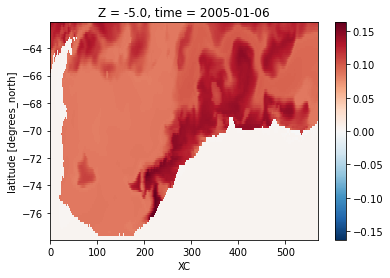

In [19]:
(-drhodt[0,0]).drop('XC').plot()

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta} \dot \theta \end{equation*} </font>

In [24]:
ds_sig_theta = (drhodt * ds_tmp)#.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'time':1})

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array

In [21]:
ds_sig_theta

<xarray.Dataset>
Dimensions:                  (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float64 0.08333 0.25 0.4167 ... 359.8 359.9
  * YC                       (YC) float64 -77.87 -77.71 -77.54 ... -62.37 -62.21
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH          (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [25]:
rhs_theta = (ds_sig_theta.conv_horiz_adv_flux_TH + 
              ds_sig_theta.conv_horiz_diff_flux_TH + 
              ds_sig_theta.conv_vert_adv_flux_TH +
              ds_sig_theta.conv_vert_diff_flux_TH + 
              ds_sig_theta.surface_flux_conv_TH + 
              ds_sig_theta.sw_flux_conv_TH)#.load()

lhs_theta = ds_sig_theta.total_tendency_TH_truth#.load()

In [26]:
#checking equality
rhs_theta[1:-1].sum(['XC', 'YC', 'Z']).plot(label='rhs', color='yellow')
lhs_theta[1:-1].sum(['XC', 'YC', 'Z']).plot(label='lhs')
plt.legend();

KeyboardInterrupt: 

In [ ]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
rhs_theta[1:-1].mean(dim=['time', 'Z']).plot(ax=ax0, vmax=6)
ax0.set_title('rhs')
lhs_theta[1:-1].mean(dim=['time', 'Z']).plot(ax=ax1, vmax=6)
ax1.set_title('lhs')
plt.tight_layout();

In [ ]:
rhs_vars = [dvar for dvar in ds_sig_theta.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_sig_theta[dvar] for dvar in rhs_vars])
total_tendency_check

In [ ]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[200, 0].plot(ax=ax0, robust=True, vmax=200)
ax0.set_title('RHS')

ds_sig_theta.total_tendency_TH_truth[200, 0].plot(ax=ax1, robust=True, vmax=200)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'> \begin{equation*} Salinity \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \end{equation*} </font>

In [22]:
drhods = xr.apply_ufunc(jmd95numba.drhods, ds_wg.SALT, ds_wg.THETA, pref,
                        output_dtypes=[ds_wg.SALT.dtype],
                        dask='parallelized').reset_coords(drop=True).load()

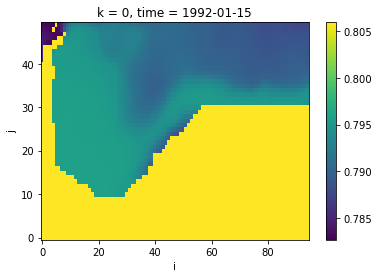

In [23]:
drhods[0,0].plot()

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \dot S \end{equation*} </font>

In [24]:
ds_sig_salt = drhods * ds_slt

In [25]:
ds_sig_salt

<xarray.Dataset>
Dimensions:     (i: 95, j: 50, k: 50, time: 288)
Coordinates:
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    G_adv       (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_adv_conv  (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_diff      (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_forc      (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_tot       (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>

In [26]:
rhs_salt = (ds_sig_theta.conv_horiz_adv_flux_SLT + 
            ds_sig_theta.conv_horiz_diff_flux_SLT + 
            ds_sig_theta.conv_vert_adv_flux_SLT +
            ds_sig_theta.conv_vert_diff_flux_SLT + 
            ds_sig_theta.surface_flux_conv_SLT).load()

lhs_salt = ds_sig_salt.total_tendency_SLT_truth.load()

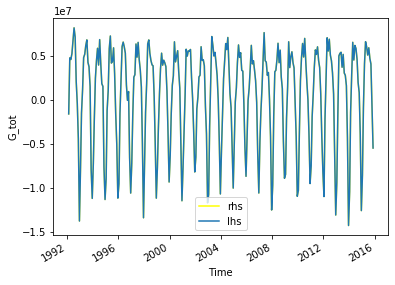

In [27]:
#checking equality
rhs_salt[1:-1].sum(['XC', 'YC', 'Z']).plot(label='rhs', color='yellow')
lhs_salt[1:-1].sum(['XC', 'YC', 'Z']).plot(label='lhs')
plt.legend();

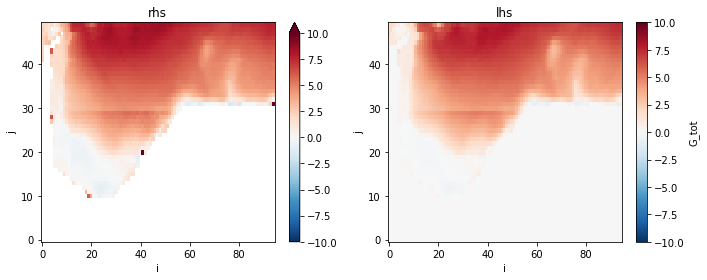

In [29]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
rhs_salt[1:-1].mean(dim=['time', 'Z']).plot(ax=ax0, vmax=10)
ax0.set_title('rhs')
lhs_salt[1:-1].mean(dim=['time', 'Z']).plot(ax=ax1, vmax=10)
ax1.set_title('lhs')
plt.tight_layout();

In [30]:
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
            if dvar != 'total_tendency_SLT_truth']
total_tendency_check_salt = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check_salt

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float64, chunksize=(48, 50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

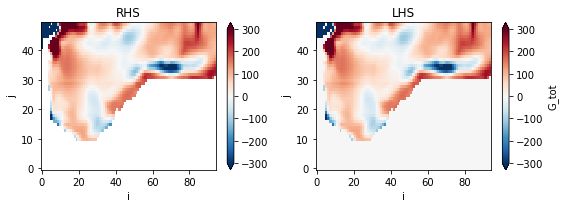

In [31]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check_salt[200, 0].plot(ax=ax0, robust=True, vmax=300)
ax0.set_title('RHS')

ds_sig_salt.total_tendency_SLT_truth[200, 0].plot(ax=ax1, robust=True, vmax=300)
ax1.set_title('LHS')
plt.tight_layout();

## Saving Data

In [32]:
drhodts = xr.merge([drhodt.rename('drhodt'), drhods.rename('drhods')])

In [33]:
import json
with open('/home/jovyan/WMT/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [111]:
#saving theta component of drho/dtime
gcsmap_sig_theta = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_theta.zarr')
ds_sig_theta.to_zarr(gcsmap_sig_theta, mode='w')

In [34]:
#saving salt component of drho/dtime
gcsmap_sig_salt = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_salt_new.zarr')
ds_sig_salt.to_zarr(gcsmap_sig_salt, mode='w')

In [35]:
#saving rhodt and drhods
gcsmap_drhodts = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/drhodts_new.zarr')
drhodts.to_zarr(gcsmap_drhodts, mode='w')